## Baseball Stats

In [27]:
import os
import sqlite3 as sql
import logging

import pandas as pd
import numpy as np

from scrapers import fangraph
import bb_stat_utils

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', level=logging.INFO)
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [28]:
# Point to the SQLLTIE Db
db_path = r'/home/zach/dev/demos/2021_Baseball_PURE.db'
if not os.path.exists(db_path):
    #This may take a while (~30 mins)
    fangraphscraper = fangraph.FangraphScraper(db_path)
    fangraphscraper.generate_sqllite_tables()
conn = sql.connect(db_path)

# SQL Query
Since the data is stored on a game by game basis, it must be aggregated per player to be used from a full 2021 season perspective. 
A query in the following style can perform this:
``` 
SELECT 
name, 
id, 
SUM("AB"),
SUM("HR"), 
SUM("RBI")
FROM bat 
WHERE name like 'tatis'
GROUP BY name, id;
``` 

Note the critical inclusion of a `GROUP BY` which groups y player name and ID (the combination of which is unique in this db) and `SUM` which takes the sum of the specified catagory across the grouping. 

See a DB schema for pitching and batting by running the cell below

In [29]:
pd.read_sql("pragma table_info('BAT')", con=conn)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,Team,TEXT,0,None,0
2,2,Opp,TEXT,0,None,0
3,3,BO,TEXT,0,None,0
4,4,Pos,TEXT,0,None,0
5,5,G,INTEGER,0,None,0
6,6,AB,INTEGER,0,None,0
7,7,PA,INTEGER,0,None,0
8,8,H,INTEGER,0,None,0
9,9,1B,INTEGER,0,None,0


In [30]:
pd.read_sql("pragma table_info('PIT')", con=conn)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,Team,TEXT,0,None,0
2,2,Opp,TEXT,0,None,0
3,3,GS,INTEGER,0,None,0
4,4,W,INTEGER,0,None,0
5,5,L,INTEGER,0,None,0
6,6,G,INTEGER,0,None,0
7,7,CG,INTEGER,0,None,0
8,8,ShO,INTEGER,0,None,0
9,9,SV,INTEGER,0,None,0


### Spot Check Batting Data Quality 
According to [this baseball reference link](https://www.baseball-reference.com/players/t/tatisfe02.shtml) Tatis had the following select stats in 2021 Regular Season

| Stat  |Value |
| ------| -----|
| AB    | 478|
| HR    | 42     |
| RBI   | 97 |

Running the code below, our data set agrees


In [31]:
s = """
SELECT 
name, 
id, 
SUM("AB"),
SUM("HR"), 
SUM("RBI")
FROM bat 
WHERE name like '%tatis%'
GROUP BY name, id;
"""

tatis_df = pd.read_sql(s, con=conn)
tatis_df


,name,id,"SUM(""AB"")","SUM(""HR"")","SUM(""RBI"")"
0,fernando-tatis-jr,19709,478,42,97


### Spot Check Pitching Data Quality 
According to [this baseball reference link](https://www.baseball-reference.com/players/d/darviyu01.shtml) Yu Darvish had the following select stats in 2021 Regular Season

| Stat  |Value |
| ------| -----|
| GS    | 30|
| IP    | 166.1     | 
| H   | 138 |
|ERA | 4.22|

Running the code below, our data set agrees, Note that 0.1 is equivalent to 0.333 for innings pitched, and that ERA is a derived parameter. (ER/(IP/9))


In [32]:
s = """
SELECT 
name, 
id, 
SUM("GS"),
SUM("IP"), 
SUM("ER"), 
SUM("H")
FROM pit 
WHERE name like '%darvish%'
GROUP BY name, id;
"""
darvish_df = pd.read_sql(s, con=conn)
print(darvish_df)
darvish_df['ERA'] = darvish_df['SUM("ER")'] / ( darvish_df['SUM("IP")'] / 9)
darvish_df


         name     id  SUM("GS")   SUM("IP")  SUM("ER")  SUM("H")
0  yu-darvish  13074         30  166.333333         78       138


,name,id,"SUM(""GS"")","SUM(""IP"")","SUM(""ER"")","SUM(""H"")",ERA
0,yu-darvish,13074,30,166.333333,78,138,4.220441


Nice, our bespoke data set agrees with an indepedent data set on baseball reference! Now we can do use to draft the ultimate FBB team!

# TOPSIS - Drafting the ideal FBB Team
We can use the [topsis alogrithm](https://en.wikipedia.org/wiki/TOPSIS) (often used in design probems) to decide who is the ideal candidate for a given Baseball position wheile drafting our team.

TOPSIS relies on comparing numerical, what appears uncompareable. For example TOPSIS allows us to compare a player with 32 HRs and 11 SB to a player with 15 HR and 21 SB. 

As shown in the example above, Roto scoring weights all categories, equally, so our TOPSIS algorithm will use equal weights for all categories. As discussed below this does not imply that stolen bases and home runs are equally as common. 

TOPSIS compares all entries (players in this case) and determines which player have the lowest distance from ideal. 

##### Catagorical Rarity - Modification to TOPSIS
The TOPSIS algortithm presented here has actually been slightly modified from the text book definition to account for scarcity, for example RBIs being more common than HR. To see this look into the `topsis` function itself and note the second normalization step not typically present in textbook definitions

## First Cut - No Knowledge of Team Make Up
The analysis below shows the rankings and relative values of all players for the given position (or in pitching just all pitchers)

The offsensive categories are standard in FBB and are the catagories used in the author's league. (OBP- On Base Percentage and SLUG -Slugging Percentage are derived metrics)



In [33]:
bat_cats = ['HR', 'RBI', 'SB','OBP', 'SLG']
bat_cats_power = {key: 1.0 for key in bat_cats} # This should be negative if a lower value is desired (ie offesnive strikeouts)
unique_pos = ['fDH', 'fC', 'f1B', 'F2B', 'fSS', 'f3B', 'fPH', 'fLF', 'fCF', 'fRF']

bat_raw_cats = ['HR', 'RBI', 'SB', '1B', '2B', '3B', 'HBP', 'BB']
bat_rename_cats =  {f'SUM("{cat}")': cat for cat in bat_raw_cats + unique_pos}


pit_cats = ['ER', 'QS_STAND', 'SV', 'WH', 'SO', 'IP'] # TODO would derive a true QS metric from definition
pit_cats_power = {'ER': -1.0, 'QS_STAND': 1.0, 'SV': 1.0, 'WH': -1.0, 'SO': 1.0, 'IP' : 1.0}

pit_raw_cats = ['ER', 'SV', 'SO', 'IP', 'BB', 'W', 'H', 'GS', 'L']
pit_rename_cats =  {f'SUM("{cat}")': cat for cat in pit_raw_cats}


,name,fDH,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
20,shohei-ohtani,125,46,100,26,238,318,0.567945,1.255578,1.000000
0,aaron-judge,21,39,98,6,236,299,1.823523,0.005098,-0.131120
23,vladimir-guerrero-jr,28,48,111,4,280,363,1.828621,0.313822,0.148136
19,salvador-perez,36,48,121,1,210,337,2.142443,0.077143,-0.065952
14,mitch-haniger,33,39,100,1,220,301,2.219586,0.025051,-0.113071
17,ryan-mountcastle,39,33,89,4,181,260,2.244637,0.067853,-0.074355
2,austin-meadows,58,27,106,4,186,237,2.312490,0.000157,-0.135589
26,yordan-alvarez,97,33,104,1,207,285,2.312647,0.004082,-0.132039
16,nelson-cruz,132,32,86,3,194,255,2.316729,0.097924,-0.047154
5,giancarlo-stanton,108,35,97,0,205,263,2.414653,0.024619,-0.113462


,name,fC,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
33,jt-realmuto,108,17,73,13,184,209,1.784098,0.138067,0.347369
55,salvador-perez,120,48,121,1,210,337,1.922165,0.290987,0.868963
68,will-smith,112,25,76,3,183,205,2.213152,0.102967,0.227647
70,willson-contreras,114,21,57,5,164,181,2.316119,0.329404,1.000000
16,christian-vazquez,122,6,49,8,153,161,2.645523,0.108797,0.247531
44,mike-zunino,104,33,62,0,113,186,2.754320,0.007698,-0.097308
22,eric-haase,59,22,61,2,109,161,2.762017,0.008527,-0.094478
72,yadier-molina,117,11,66,3,140,163,2.770544,0.081945,0.155944
11,buster-posey,102,18,56,0,177,197,2.852490,0.015797,-0.069680
74,yasmani-grandal,74,23,62,0,157,145,2.868287,0.058192,0.074924


,name,f1B,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
35,paul-goldschmidt,153,31,99,12,248,310,0.674040,0.256713,1.000000
17,freddie-freeman,159,31,83,8,273,302,0.930753,0.121401,0.331197
44,vladimir-guerrero-jr,132,48,111,4,280,363,1.052154,0.081742,0.135176
30,matt-olson,152,39,111,4,250,305,1.133897,0.220175,0.819407
37,pete-alonso,148,37,94,3,219,291,1.354072,0.057685,0.016267
40,ryan-mountcastle,81,33,89,4,181,260,1.411757,0.008895,-0.224886
34,nathaniel-lowe,145,18,72,8,229,231,1.420652,0.090344,0.177690
31,max-muncy,92,36,94,2,218,262,1.510996,0.076543,0.109477
2,anthony-rizzo,137,22,61,6,198,218,1.587539,0.007009,-0.234208
19,jared-walsh,124,29,98,2,199,270,1.594548,0.036501,-0.088436


,name,F2B,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
63,trea-turner,48,28,77,32,242,319,0.780541,0.166235,0.698816
54,ozzie-albies,156,30,106,20,213,307,0.946776,0.001044,-0.204849
45,marcus-semien,140,45,102,15,242,351,0.947820,0.221292,1.000000
27,javier-baez,32,31,87,18,174,248,1.169112,0.048238,0.053321
35,jorge-polanco,99,33,98,11,208,296,1.217350,0.104286,0.359927
4,brandon-lowe,117,39,99,7,209,280,1.321636,0.001246,-0.203743
64,whit-merrifield,140,10,74,40,228,262,1.322882,0.141863,0.565489
36,jose-altuve,143,31,83,5,237,294,1.464745,0.016372,-0.120997
60,tommy-edman,110,11,56,30,212,248,1.481117,0.024778,-0.075016
33,jonathan-india,146,21,69,12,237,244,1.505895,0.027697,-0.059044


,name,fSS,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
15,fernando-tatis-jr,101,42,97,25,199,292,0.426348,0.117648,0.245473
5,bo-bichette,148,29,102,25,237,310,0.543996,0.047326,-0.011726
46,trea-turner,98,28,77,32,242,319,0.591322,0.323946,1.000000
24,javier-baez,96,31,87,18,174,248,0.915268,0.074947,0.089298
47,trevor-story,138,24,75,20,196,248,0.990215,0.023466,-0.098994
27,jorge-polanco,23,33,98,11,208,296,1.013681,0.178366,0.467547
6,brandon-crawford,133,24,90,11,205,252,1.192046,0.019564,-0.113265
10,dansby-swanson,158,27,88,9,203,264,1.211610,0.076079,0.093436
45,tim-anderson,123,17,61,18,186,247,1.287689,0.081604,0.113644
25,jazz-chisholm-jr,29,18,53,23,153,197,1.369293,0.064635,0.051582


,name,f3B,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
29,jose-ramirez,132,36,103,27,226,297,0.226935,0.800026,1.000000
42,manny-machado,144,28,106,12,222,276,1.026961,0.286611,0.313753
49,rafael-devers,149,38,113,5,234,318,1.313573,0.043961,-0.010581
36,kris-bryant,36,25,73,10,207,247,1.357534,0.155142,0.138026
37,kyle-seager,148,35,101,3,191,264,1.512675,0.019682,-0.043033
46,nolan-arenado,155,34,105,2,204,293,1.532357,0.011124,-0.054473
52,ryan-mcmahon,89,23,86,6,197,237,1.543481,0.050332,-0.002065
33,justin-turner,136,27,87,3,221,251,1.593813,0.032963,-0.025281
6,austin-riley,147,33,107,0,243,313,1.626777,0.039656,-0.016335
40,luis-urias,50,23,75,5,195,218,1.666433,0.040666,-0.014985


,name,fPH,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
33,tommy-pham,28,15,49,14,191,182,0.545970,1.120541,1.000000
7,brad-miller,43,20,49,3,121,150,1.666511,0.129715,0.041695
36,wilmer-flores,26,18,53,1,146,174,1.796226,0.054967,-0.030600
11,dominic-smith,23,11,58,2,150,162,1.851193,0.044377,-0.040842
10,darin-ruf,39,16,43,2,120,136,1.895569,0.083071,-0.003417
22,jurickson-profar,33,4,33,10,135,113,1.978641,0.062319,-0.023488
1,albert-pujols,31,17,50,2,84,119,2.040960,0.140605,0.052228
34,tyler-stephenson,31,10,45,0,147,151,2.181565,0.036748,-0.048220
15,ha-seong-kim,38,8,34,6,80,94,2.218313,0.036038,-0.048907
2,alex-dickerson,24,13,38,1,95,119,2.254352,0.044017,-0.041190


,name,fLF,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
63,teoscar-hernandez,22,32,116,12,206,288,0.614106,0.015601,-0.094731
67,tyler-oneill,131,34,80,15,189,270,0.629707,0.166427,1.000000
60,robbie-grossman,73,23,67,20,239,231,0.796134,0.048715,0.145622
59,randy-arozarena,66,20,69,20,215,243,0.844849,0.128386,0.723893
46,kris-bryant,29,25,73,10,207,247,0.973236,0.089952,0.444925
41,joey-gallo,46,38,77,6,216,228,1.063187,0.029837,0.008601
1,adam-duvall,45,38,113,5,156,252,1.093024,0.059859,0.226502
7,andrew-mccutchen,132,27,80,6,192,214,1.152883,0.002114,-0.192621
32,ian-happ,48,25,66,9,172,202,1.154997,0.008570,-0.145764
51,mark-canha,85,17,61,12,224,201,1.163567,0.010625,-0.130845


,name,fCF,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
17,cedric-mullins-ii,148,30,59,30,242,312,0.807806,0.379893,1.000000
2,adolis-garcia,74,31,90,16,178,264,1.187700,0.125813,0.256522
64,starling-marte,119,12,55,47,201,214,1.313513,0.135130,0.283786
19,chris-taylor,38,20,73,13,200,222,1.448643,0.037884,-0.000772
15,bryan-reynolds,132,24,90,5,252,292,1.486527,0.112174,0.216613
31,ian-happ,41,25,66,9,172,202,1.598702,0.117400,0.231904
69,trent-grisham,119,15,62,13,172,191,1.716102,0.050457,0.036020
3,akil-baddoo,53,13,55,18,152,180,1.766559,0.034207,-0.011531
24,dylan-carlson,51,18,65,2,212,237,1.800766,0.004946,-0.097152
54,myles-straw,154,4,48,30,222,196,1.805712,0.013905,-0.070939


,name,fRF,HR,RBI,SB,OBP,SLG,distance_from_ideals,improvement,pick_value
11,bryce-harper,138,35,84,13,256,300,0.921354,0.065731,0.412094
37,kyle-tucker,131,30,92,14,203,282,0.987085,0.002538,-0.329056
57,teoscar-hernandez,72,32,116,12,206,288,0.989623,0.001112,-0.345783
3,adolis-garcia,50,31,90,16,178,264,0.990735,0.060410,0.349691
51,robbie-grossman,63,23,67,20,239,231,1.051145,0.036926,0.074255
33,juan-soto,144,29,95,9,304,268,1.088070,0.032639,0.023979
50,randy-arozarena,35,20,69,20,215,243,1.120709,0.062883,0.378698
0,aaron-judge,99,39,98,6,236,299,1.183592,0.107014,0.896278
36,kris-bryant,23,25,73,10,207,247,1.290606,0.039463,0.104014
27,joey-gallo,87,38,77,6,216,228,1.330069,0.005911,-0.289501


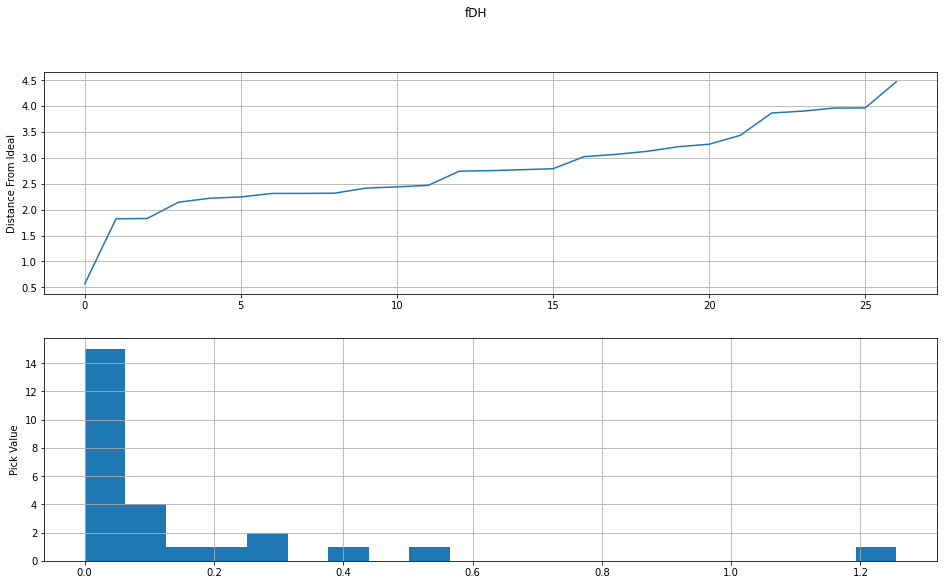

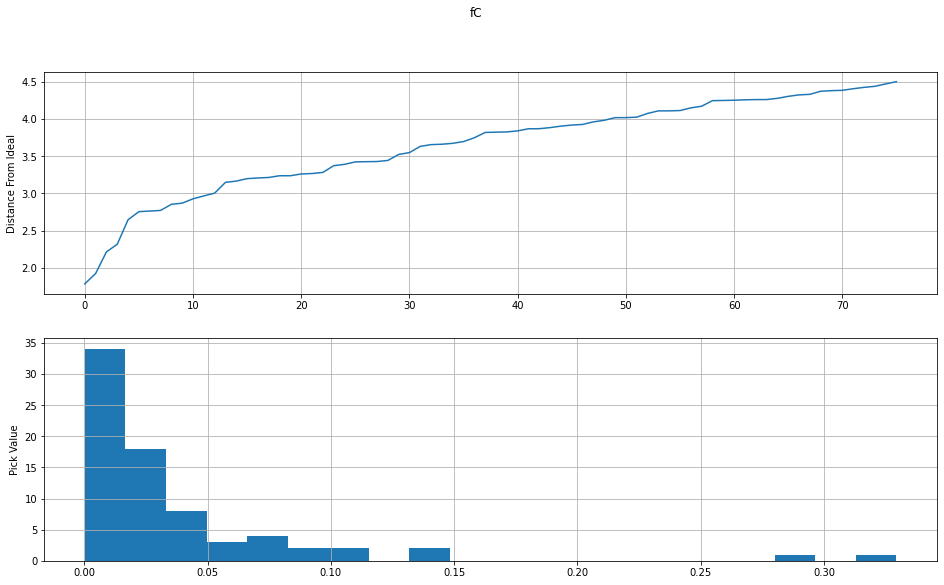

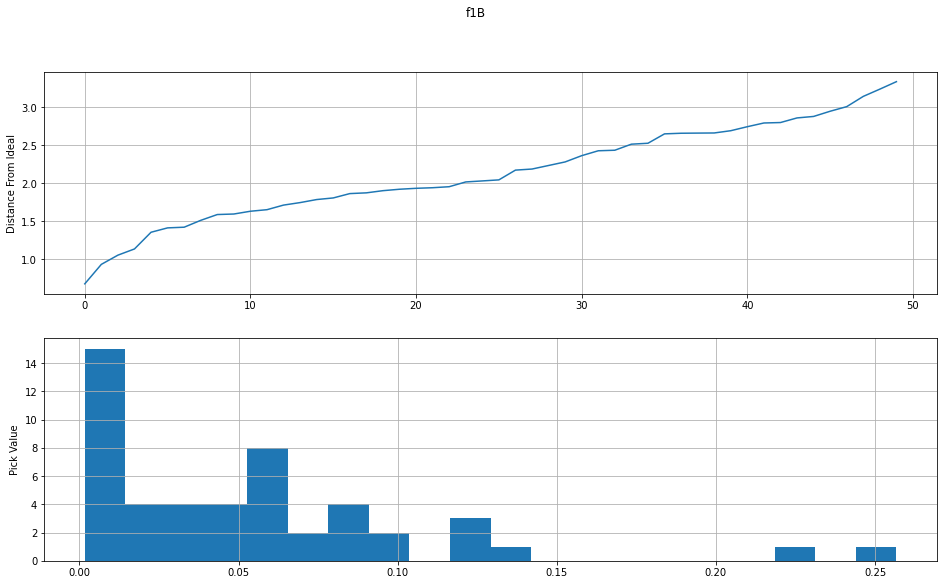

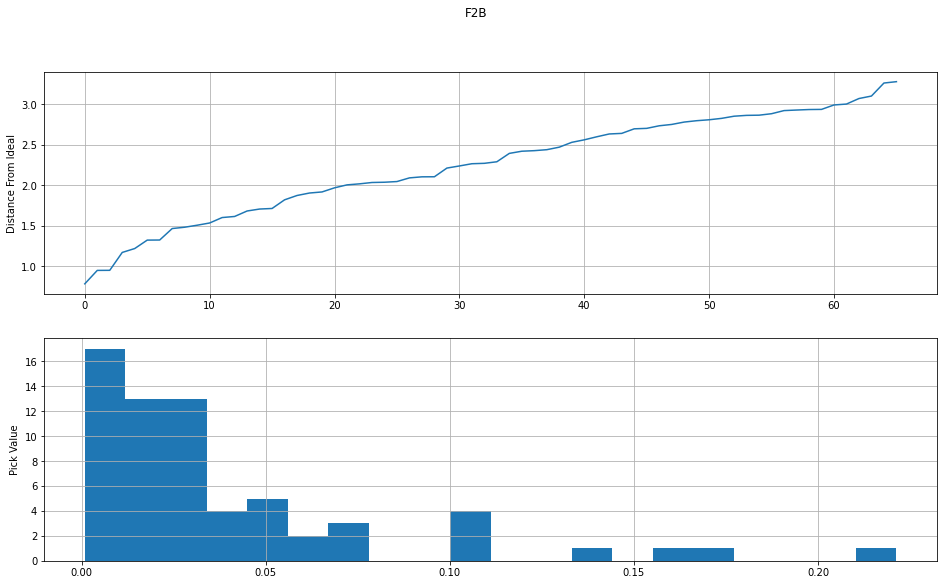

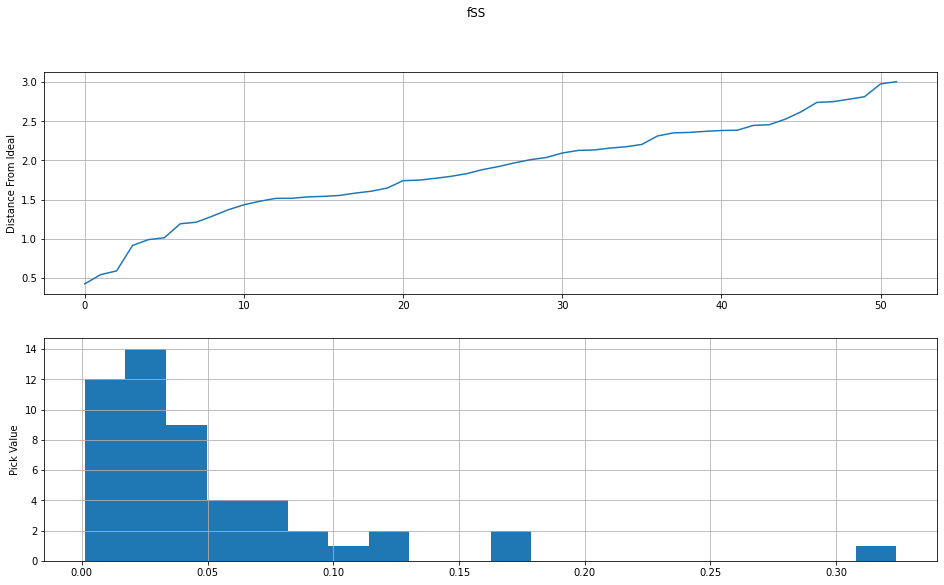

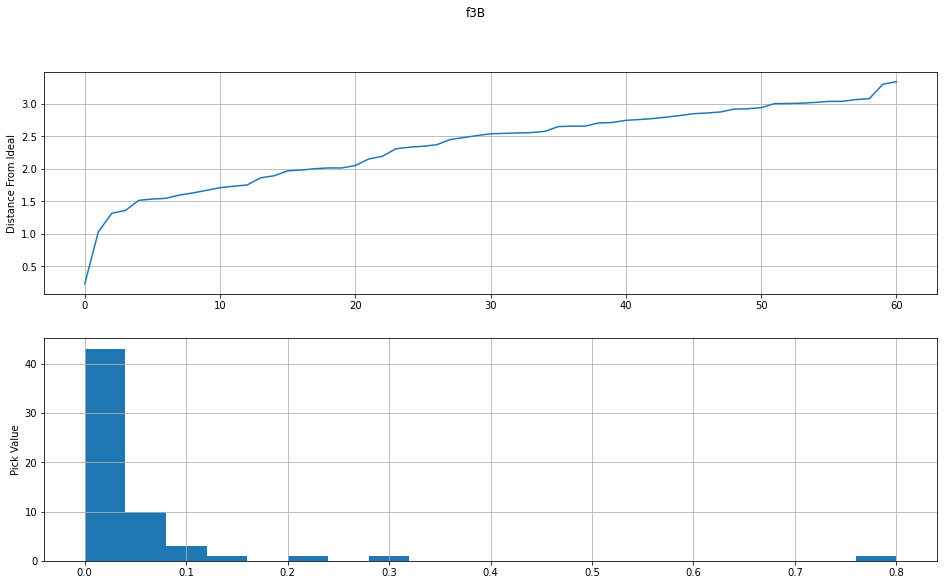

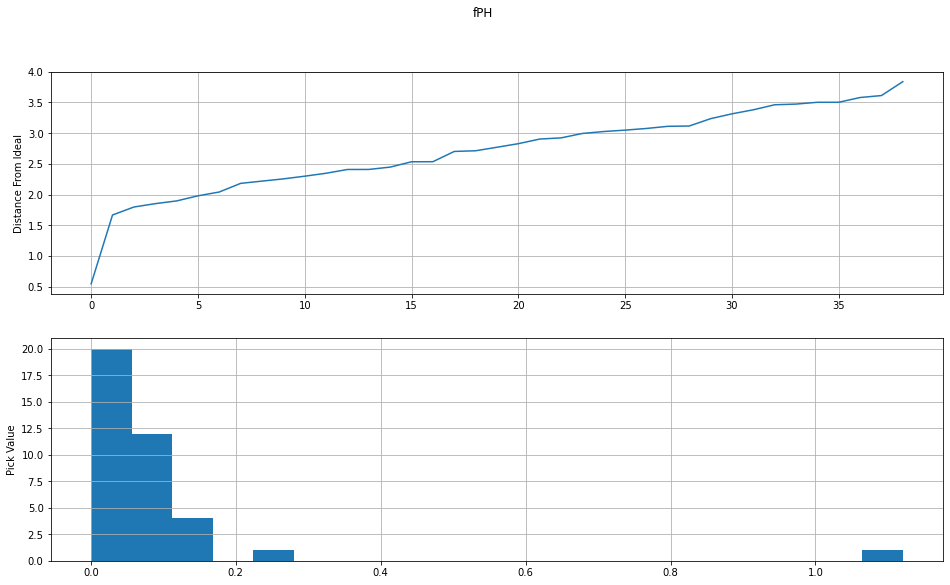

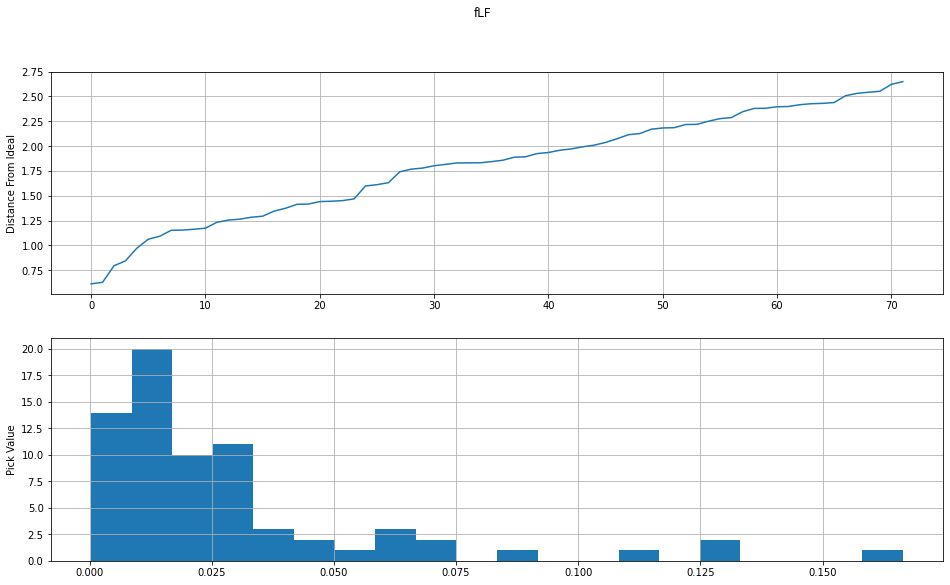

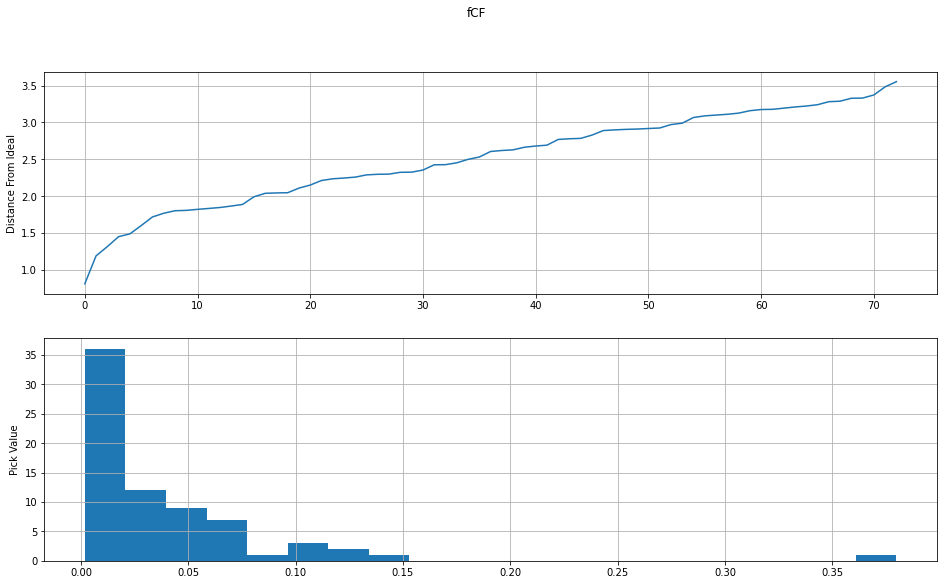

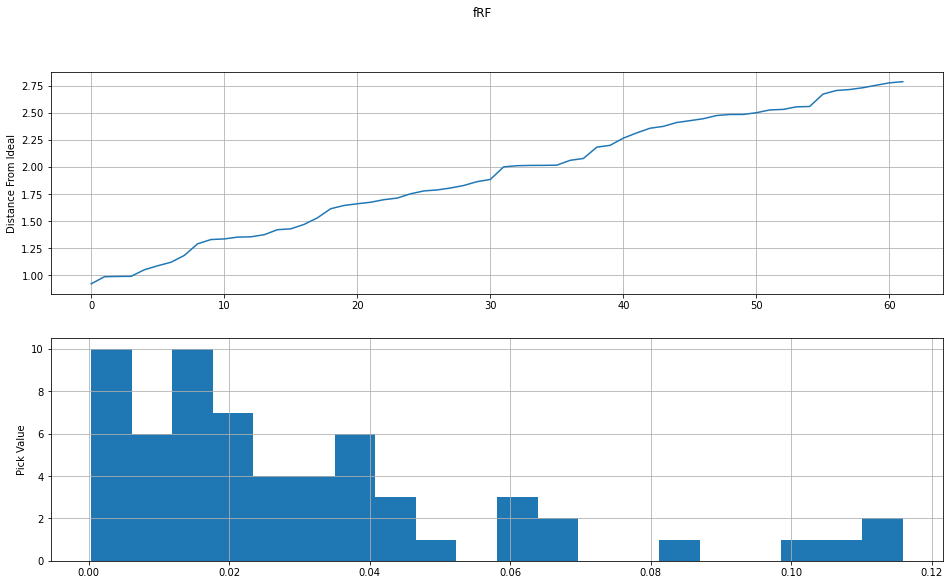

In [34]:

# Query independent of position
# Only Keep players with greater than 20 appearances at the given position
query = \
"""SELECT
name,
id,
SUM("{0}"),
SUM("{1}"),
SUM("{2}"),
SUM("{3}"),
SUM("{4}"),
SUM("{5}"),
SUM("{6}"),
SUM("{7}"),
SUM("{8}")
FROM bat
WHERE '{8}' > 1
GROUP BY name, id
HAVING SUM("{8}")>20;
"""

for pos in unique_pos:
    pos_df = pd.read_sql(query.format(*bat_raw_cats,pos), con=conn)
    pos_df.rename(mapper=bat_rename_cats, axis=1, inplace=True)
    bb_stat_utils.calc_SLG_OBP(pos_df)
    if len(pos_df) > 0:
        score_df = bb_stat_utils.topsis(df=pos_df, cats=bat_cats, cats_power=bat_cats_power,  csv_name=None)
        bb_stat_utils.determine_pick_value(score_df)
        display(HTML(f'<h1>{pos}</h1><b>' + score_df.iloc[:10][['name' ,  pos] + bat_cats + ['distance_from_ideals', 'improvement', 'pick_value']].to_html()+'<\b>'))
        
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,9))
        fig.suptitle(pos)
        ax[0].plot(score_df['distance_from_ideals'].values)
        ax[0].set_ylabel('Distance From Ideal')
        ax[1].hist(score_df['improvement'].values, bins=20)
        ax[1].set_ylabel('Pick Value')
        ax[0].grid()
        ax[1].grid()        

In [35]:
query = \
"""SELECT
name,
id,
SUM("{0}"),
SUM("{1}"),
SUM("{2}"),
SUM("{3}"),
SUM("{4}"),
SUM("{5}"),
SUM("{6}"),
SUM("{7}"),
SUM("{8}")
FROM pit
GROUP BY name, id
HAVING SUM("IP")>20;
"""

pit_df = pd.read_sql(query.format(*pit_raw_cats), con=conn)
pit_df.rename(mapper=pit_rename_cats, axis=1, inplace=True)

bb_stat_utils.calc_WH(pit_df)
score_df = bb_stat_utils.topsis(df=pit_df, cats=pit_cats, cats_power=pit_cats_power, csv_name=None)
bb_stat_utils.determine_pick_value(score_df)

display(HTML(f'<h1>Pitching</h1>' + score_df.iloc[:5][ ['name']+ pit_cats + ['distance_from_ideals']].to_html()))


,name,ER,QS_STAND,SV,WH,SO,IP,distance_from_ideals
291,josh-hader,8,0,34,49,102,58.666667,1.603155
374,max-scherzer,49,26,0,155,236,179.333333,1.613840
224,jacob-degrom,11,13,0,51,146,92.000000,1.622830
126,corbin-burnes,45,23,0,157,234,167.000000,1.627961
537,walker-buehler,57,29,0,201,212,207.666667,1.628640
